# 1) Imports

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")

# 2) Coleta dos Dados

In [109]:
df = pd.read_csv(r'..\Dados\Dados_Imputacao\tabela_final_knn.csv')
df

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,QUAL_MED_AGUA,DIST_CORPO_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.552,3.608,54.40,...,22.45,6.27,24.10,11.76,28.61,62.268456,42.035186,24042.166072,0.000013,0.245423
1,2700706,AL,BATALHA,-9.67420,-37.1330,30.712,35.876,4.572,3.608,12.62,...,30.84,8.85,33.44,20.53,40.54,66.758485,24.642419,24257.110578,0.000164,0.384829
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.104,53.240,3.928,3.072,27.12,...,38.11,12.42,41.81,30.29,49.99,66.758485,3.297594,24226.863743,0.000447,0.298063
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.364,41.308,4.072,3.264,49.04,...,40.61,13.56,43.81,30.14,51.12,66.758485,58.541833,24358.206538,0.000276,0.419781
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.896,38.748,4.528,3.572,20.84,...,40.35,15.27,44.16,28.31,51.97,71.338777,68.942666,24734.221802,0.000169,0.366838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2806008,SE,RIBEIROPOLIS,-10.53570,-37.4380,36.320,41.788,4.036,3.456,64.68,...,28.50,6.08,30.60,11.60,36.26,63.883423,1.388835,23891.778664,0.000160,0.211261
1257,2807006,SE,SAO MIGUEL DO ALEIXO,-10.38470,-37.3836,33.176,47.952,3.992,3.124,62.08,...,33.54,7.79,37.03,18.32,44.72,63.883423,16.508752,23954.902605,0.000760,0.196098
1258,2807105,SE,SIMAO DIAS,-10.73870,-37.8097,37.960,45.236,4.152,3.348,61.38,...,26.78,7.36,28.90,14.39,34.16,63.883423,2.685846,23918.838452,0.000074,0.254938
1259,2807303,SE,TELHA,-10.20640,-36.8818,31.636,47.600,4.452,3.576,45.66,...,27.33,5.38,29.62,14.00,35.41,66.862432,4.298665,23869.921712,0.000923,0.222838


# 2) Análise Exploratória

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IBGE7                1261 non-null   int64  
 1   UF                   1261 non-null   object 
 2   NOME                 1261 non-null   object 
 3   LATITUDE             1261 non-null   float64
 4   LONGITUDE            1261 non-null   float64
 5   DIST_EF_PUB          1261 non-null   float64
 6   DIST_EM_PUB          1261 non-null   float64
 7   IDEB_AI              1261 non-null   float64
 8   IDEB_AF              1261 non-null   float64
 9   DOCSUP_EF_PUB        1261 non-null   float64
 10  DOCSUP_EM_PUB        1261 non-null   float64
 11  TXNASC7C             1261 non-null   float64
 12  TXNBAIXOP            1261 non-null   float64
 13  PINTERSAP            1261 non-null   float64
 14  PINTERDRSAI          1261 non-null   float64
 15  REN_PIBPC_D          1261 non-null   f

Plote das distribuições

In [111]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]   

In [112]:

class Subplots:
    def __init__(self, n_linhas, n_colunas) -> None:
        self.n_colunas = n_colunas
        self.n_linhas = n_linhas
    
    
    def violin(self, df):
        fig, ax = plt.subplots(ncols=self.n_colunas, nrows=self.n_linhas, sharex=False, sharey=False, figsize=(20, 35))
        for linha in range(self.n_linhas):
            for coluna in range(self.n_colunas):
                index_coluna = linha * self.n_colunas + coluna
                if index_coluna < len(columns): 
                    sns.violinplot(x=df[df.columns[index_coluna]], color='skyblue', ax=ax[linha][coluna])
                    ax[linha][coluna].set_title(f'Distribuição de {df.columns[index_coluna]}')  # Título do gráfico
                    ax[linha][coluna].set_xlabel("Value")
                    ax[linha][coluna].set_ylabel("Distribution")
                else:
                    ax[linha][coluna].set_visible(False)
        plt.tight_layout()
        plt.show()


    def box(self, df):
        fig, ax = plt.subplots(ncols=self.n_colunas, nrows=self.n_linhas, sharex=False, sharey=False, figsize=(20, 35))
        for linha in range(self.n_linhas):
            for coluna in range(self.n_colunas):
                index_coluna = linha * self.n_colunas + coluna
                if index_coluna < len(columns): 
                    sns.boxplot(x=df[df.columns[index_coluna]], color='skyblue', ax=ax[linha][coluna])
                    ax[linha][coluna].set_title(f'Distribuição de {df.columns[index_coluna]}')  # Título do gráfico
                    ax[linha][coluna].set_xlabel("Value")
                    ax[linha][coluna].set_ylabel("Distribution")
                else:
                    ax[linha][coluna].set_visible(False)
        plt.tight_layout()
        plt.show()

In [113]:
# Instanciando uma classe para subplots:
sub = Subplots(10, 6)

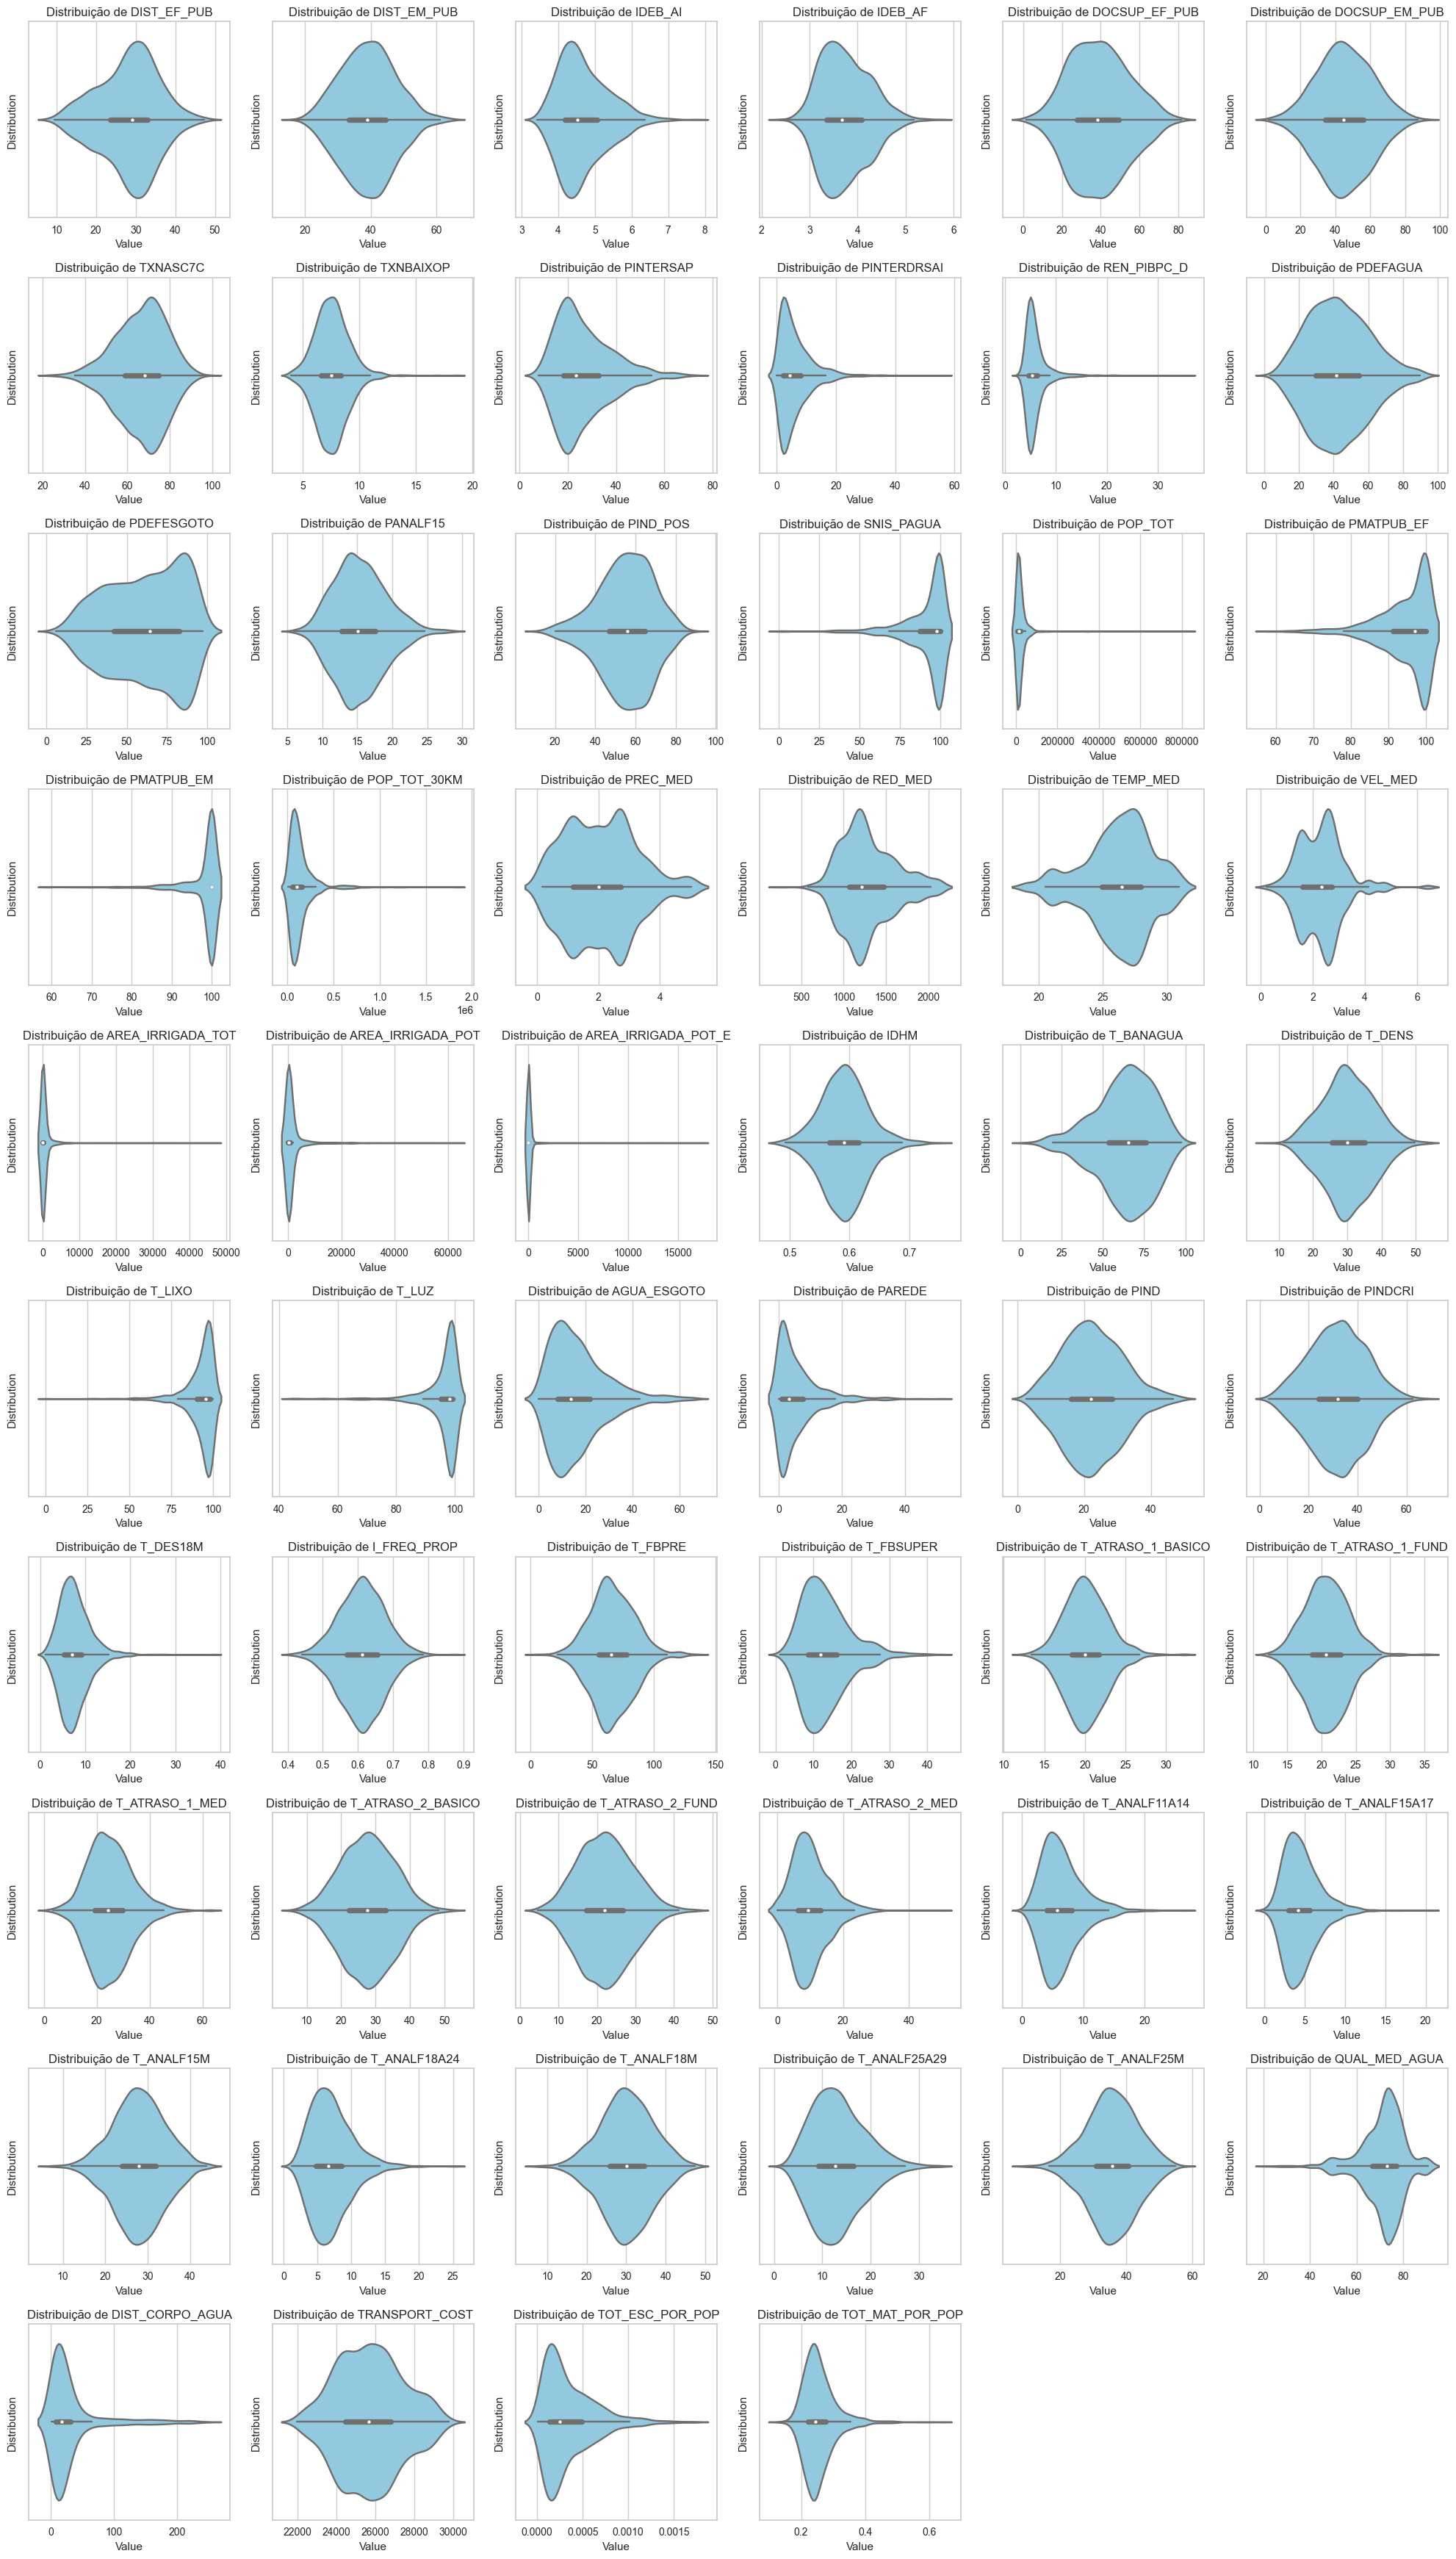

In [114]:
# Violin subplots da distribuição das variáveis
sub.violin(df[columns])

Iremos plotar os Boxplots para averiguar Outliers

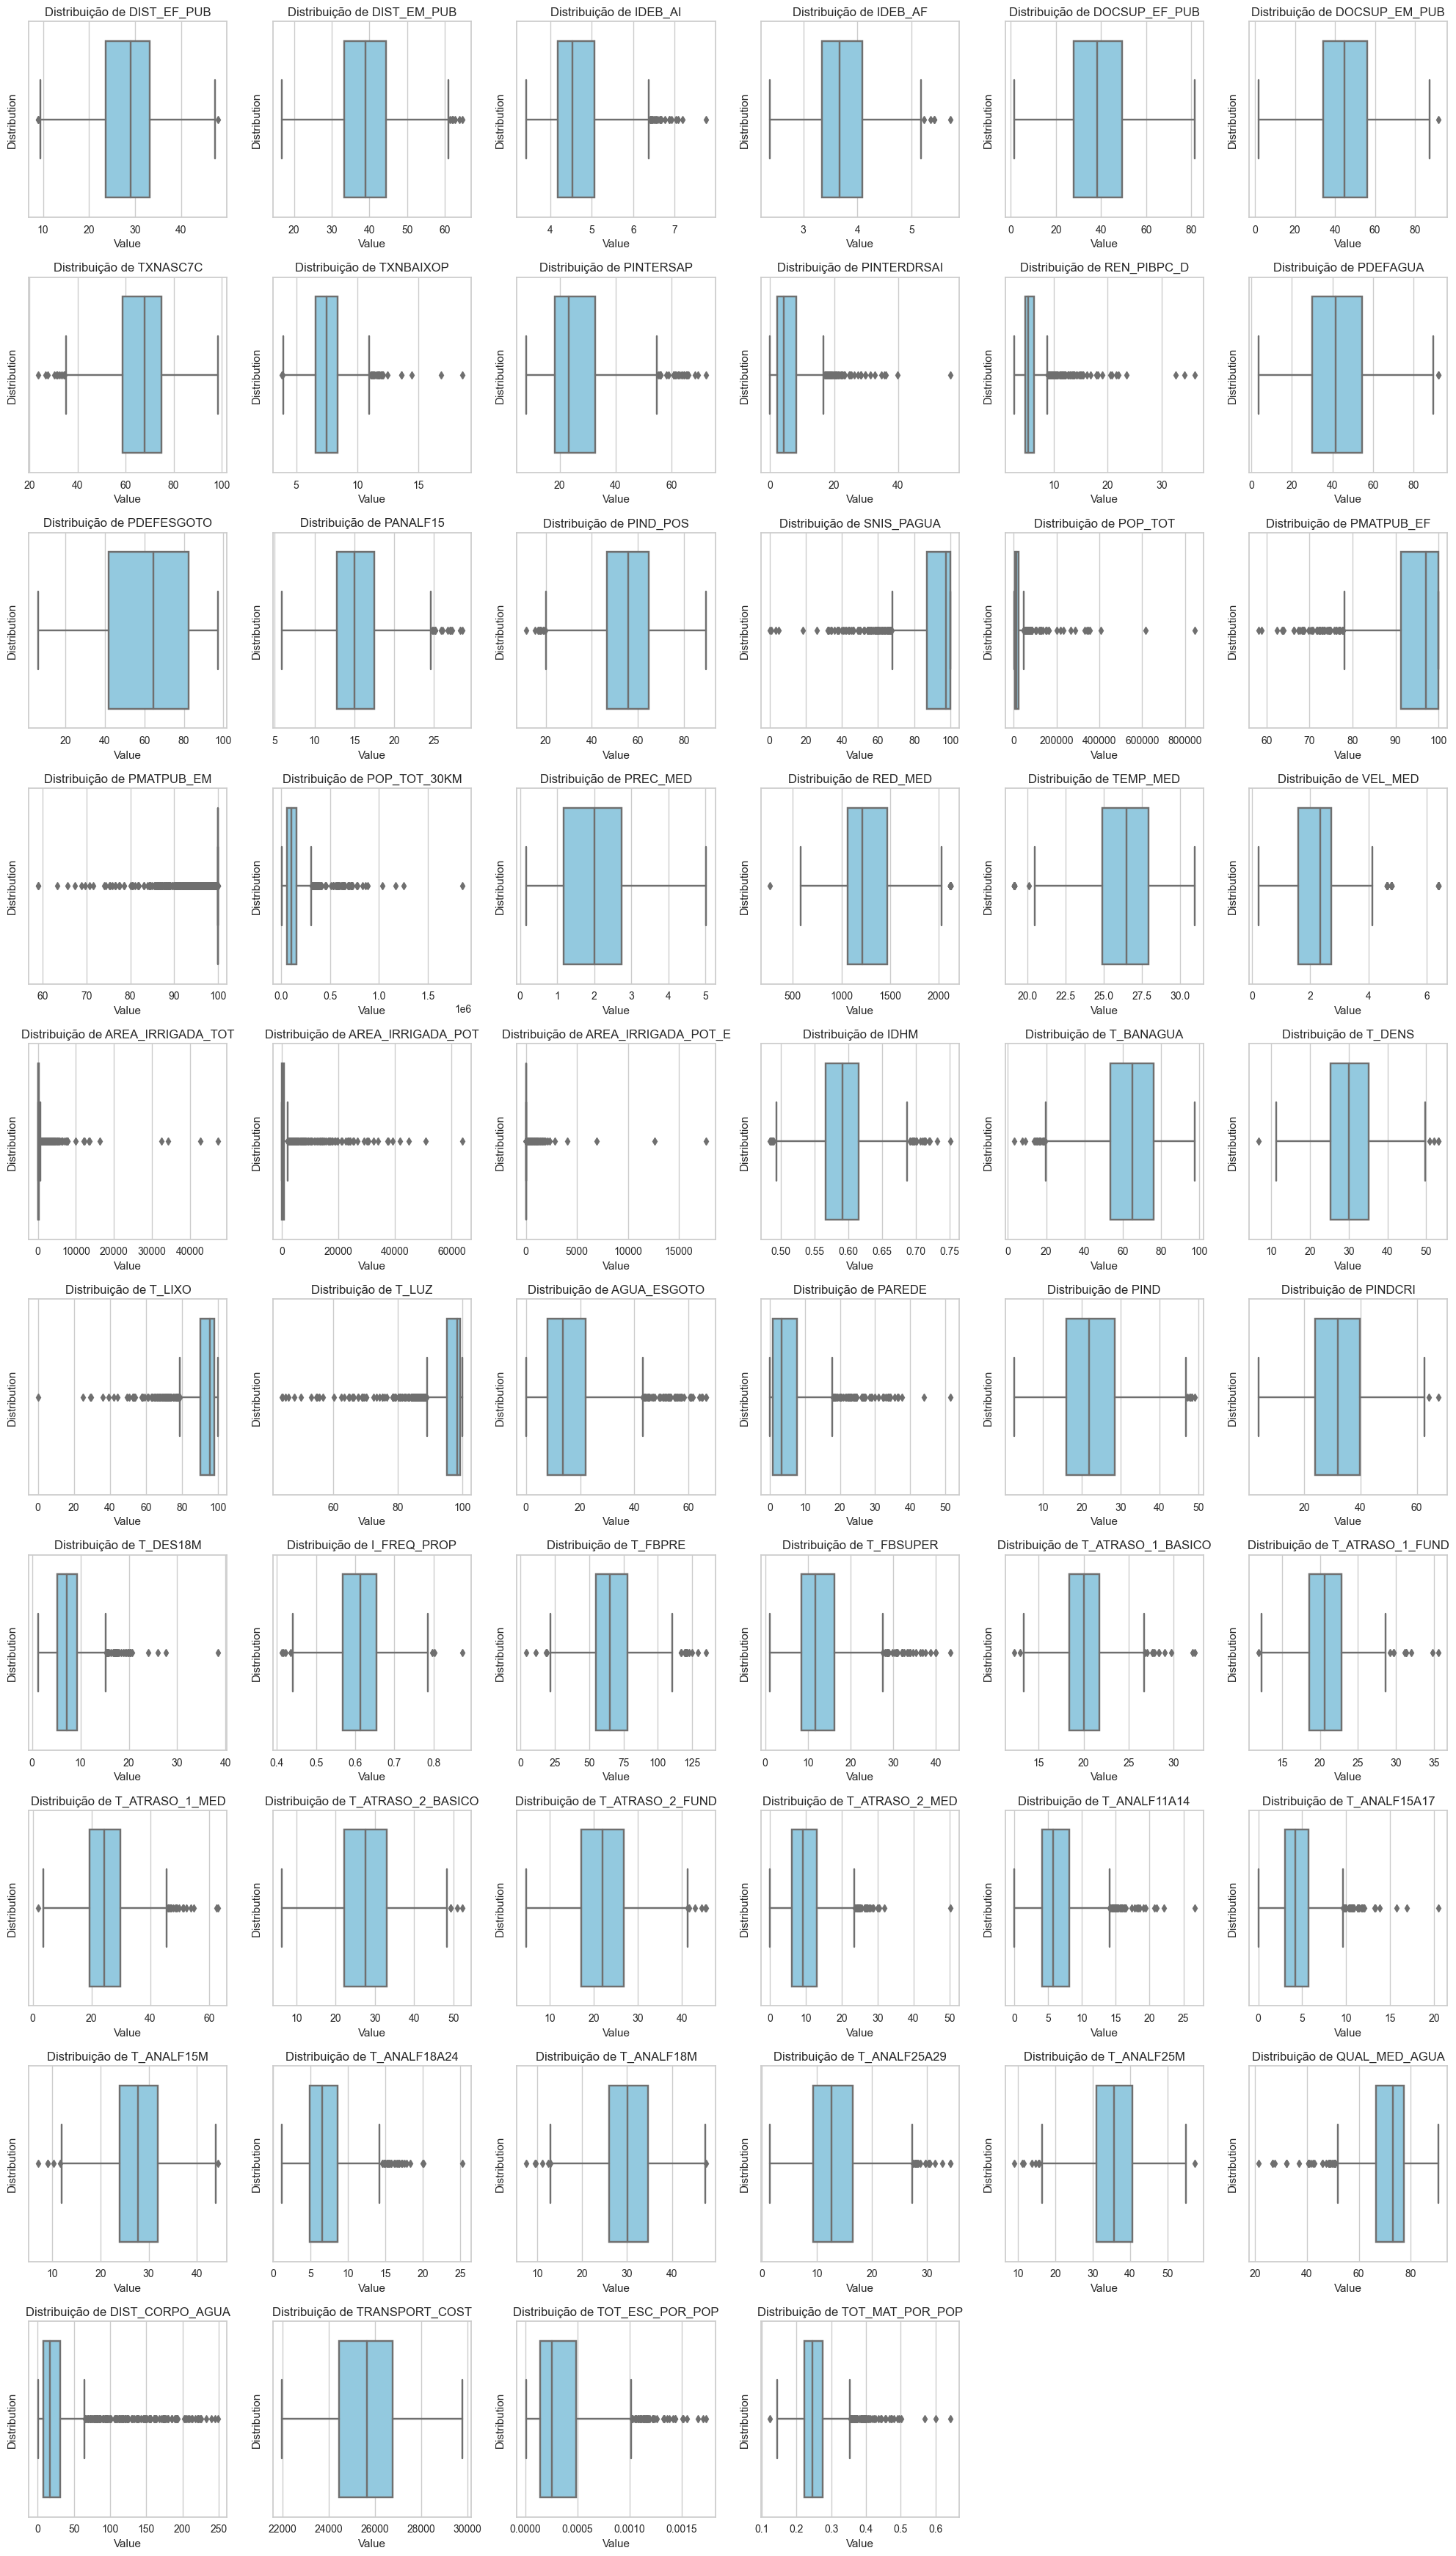

In [115]:
sub.box(df[columns])

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

In [116]:
df_pp = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pp[columns])

## 3.2) Aplicação do PCA

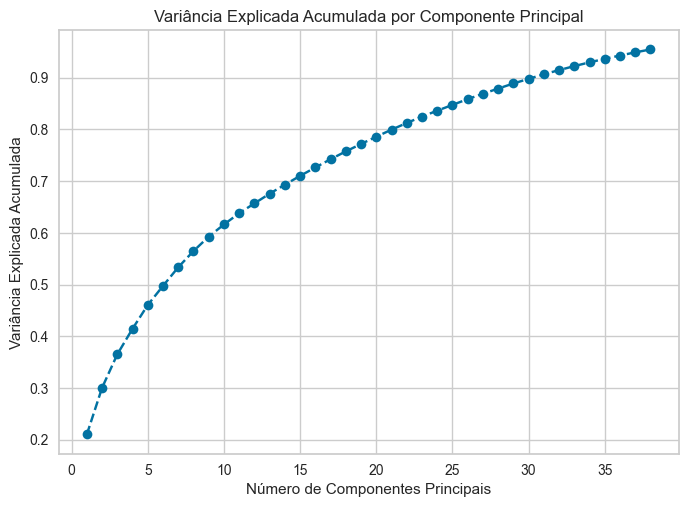

In [117]:
# Aplicar o PCA
pca = PCA(n_components = 0.95)
df_pca = pca.fit_transform(df_scaled)

# Calcular a variância explicada para cada componente principal
variancia_explicada = pca.explained_variance_ratio_

# Plotar a variância explicada acumulada
variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

In [118]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[['NOME', 'COMPONENT1', 'COMPONENT2', 'CLUSTER']].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='COMPONENT1', y='COMPONENT2', hue='CLUSTER', palette='Set2')
    sns.scatterplot(data=actual_cities, x='COMPONENT1', y='COMPONENT2', marker = 'X', color='black', s=100, label='Cidades atuais')
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] + 0.1, row['COMPONENT2'], row['NOME'], fontsize=12)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

### 3.3.1) Hierarchical Clustering

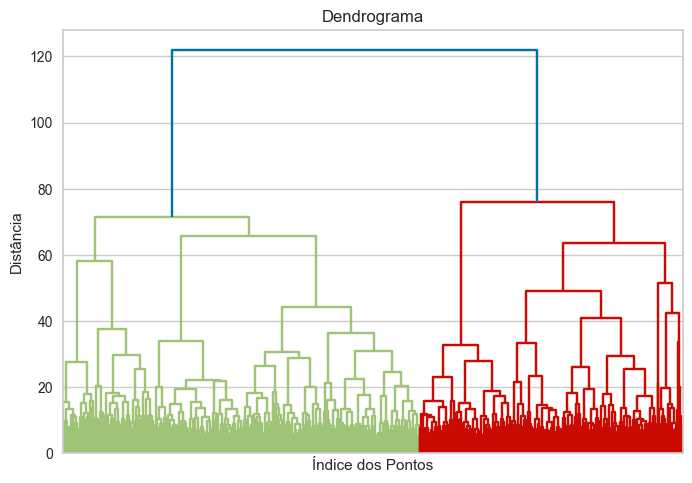

In [119]:
linkage_matrix = linkage(df_pca, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.0968
Davies-Bouldin Score:  2.751
Calinski-Harabasz Index:  149.8841


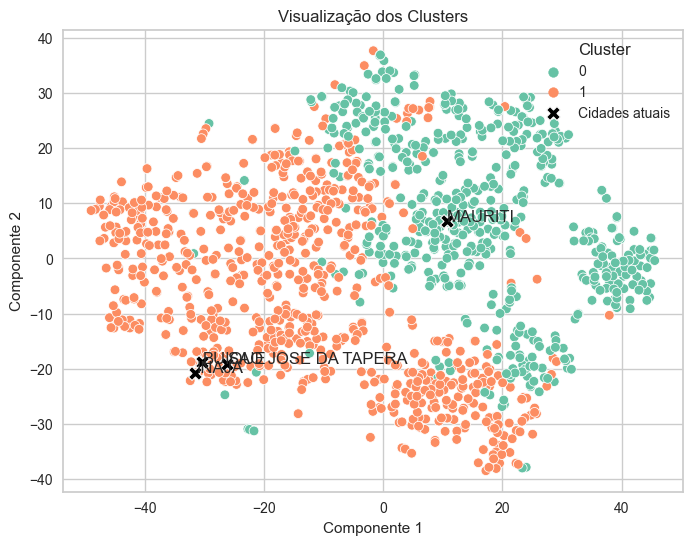

In [120]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.3.2) K-Means

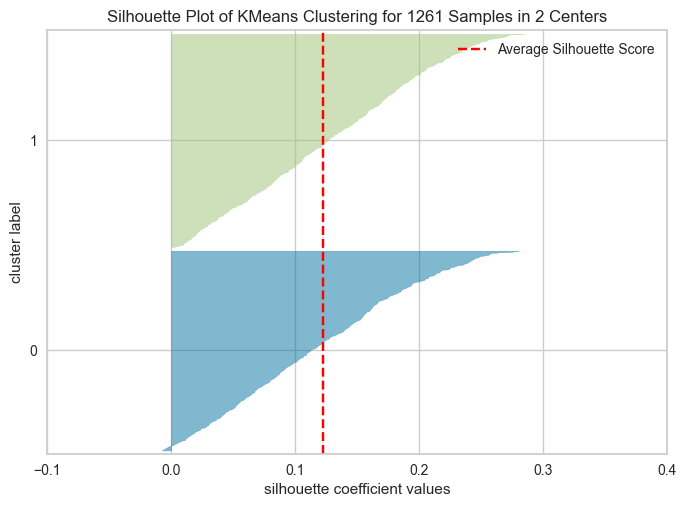

In [121]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,13):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_pca, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_pca, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1225
Davies-Bouldin Score:  2.4096
Calinski-Harabasz Index:  200.0083


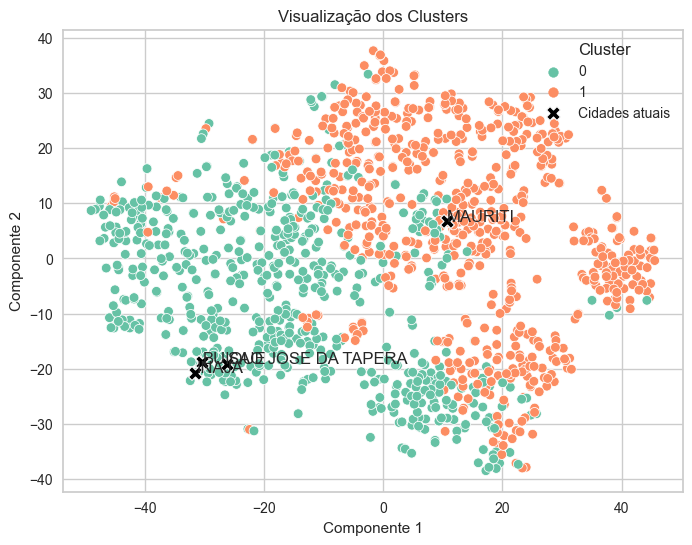

In [122]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_pca)
print('Silhouette Score: ',round(silhouette_score(df_pca, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_pca, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_pca, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [123]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_selected = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'TXNBAIXOP', 'PINTERSAP', 'PINTERDRSAI',
       'REN_PIBPC_D', 'PDEFAGUA', 'PDEFESGOTO', 'PANALF15', 'PIND_POS',
       'SNIS_PAGUA', 'POP_TOT', 'PMATPUB_EF', 'PMATPUB_EM', 'POP_TOT_30KM',
       'PREC_MED', 'RED_MED', 'TEMP_MED', 'VEL_MED', 'AREA_IRRIGADA_TOT',
       'AREA_IRRIGADA_POT', 'AREA_IRRIGADA_POT_E', 'IDHM', 'T_BANAGUA',
       'T_DENS', 'T_LIXO', 'T_LUZ', 'AGUA_ESGOTO', 'PAREDE', 'PIND', 'PINDCRI',
       'T_DES18M', 'I_FREQ_PROP', 'T_FBPRE', 'T_FBSUPER', 'T_ATRASO_1_BASICO',
       'T_ATRASO_1_FUND', 'T_ATRASO_1_MED', 'T_ATRASO_2_BASICO',
       'T_ATRASO_2_FUND', 'T_ATRASO_2_MED', 'T_ANALF11A14', 'T_ANALF15A17',
       'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29',
       'T_ANALF25M', 'QUAL_MED_AGUA', 'DIST_CORPO_AGUA', 'TRANSPORT_COST',
       'TOT_ESC_POR_POP', 'TOT_MAT_POR_POP'],
      dtype='object')

## 3.5) Nova aplicação do PCA

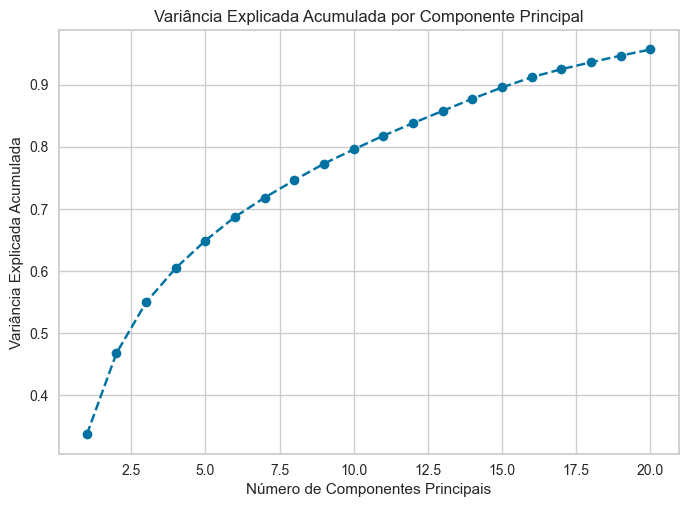

In [124]:
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected)
df_selected_pca = pca.fit_transform(df_selected_scaled)

# Calcular a variância explicada para cada componente principal
variancia_explicada = pca.explained_variance_ratio_

# Plotar a variância explicada acumulada
variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [125]:
tsne = TSNE(n_components=2, random_state=42)
df_components = tsne.fit_transform(df_selected_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.1) Hierachical Clustering

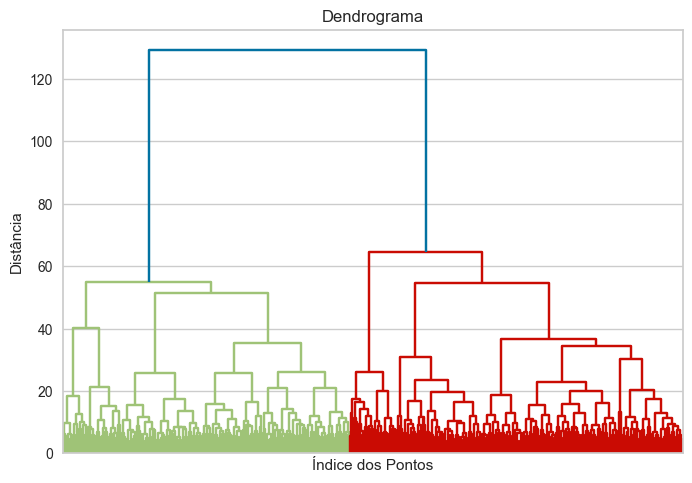

In [126]:
linkage_matrix = linkage(df_selected_pca, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.0904
Davies-Bouldin Score:  2.2271
Calinski-Harabasz Index:  172.2574


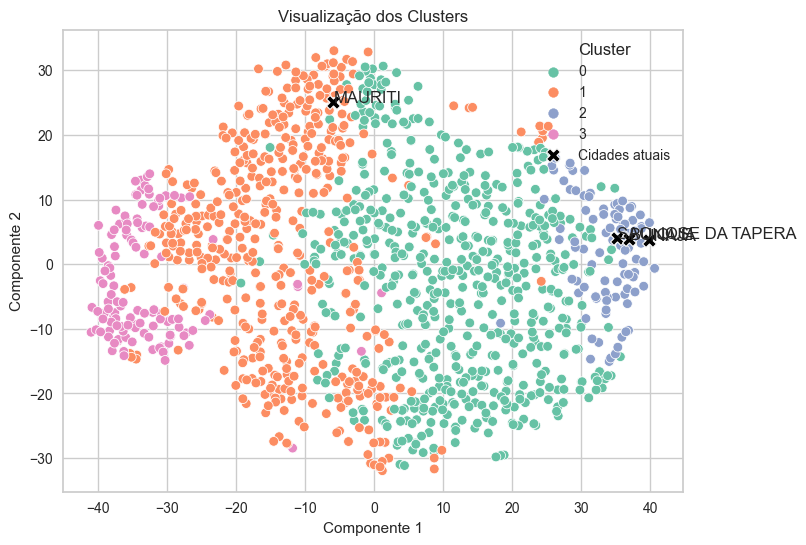

In [127]:
hclustering = AgglomerativeClustering(n_clusters=4)
h_clusters = hclustering.fit_predict(df_selected_pca)
print('Silhouette Score: ',round(silhouette_score(df_selected_pca, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_selected_pca, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_selected_pca, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.6.2) K-Means

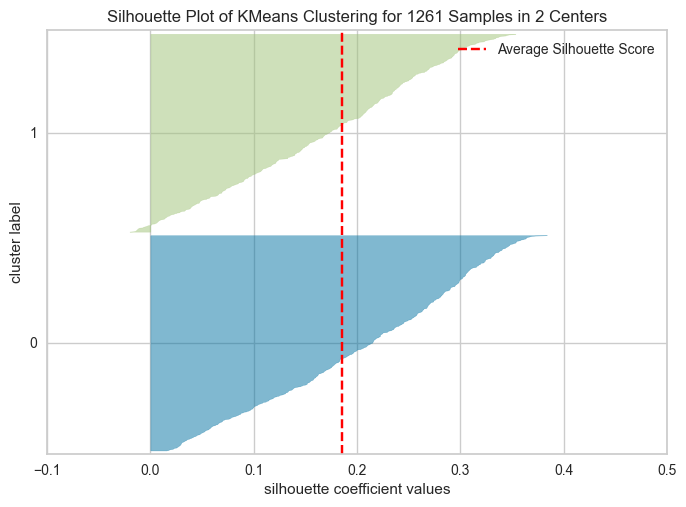

In [128]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,13):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_selected_pca)
    score = silhouette_score(df_selected_pca, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_selected_pca, colors='yellowbrick')
plt.show()

Silhouette Score:  0.1196
Davies-Bouldin Score:  2.0282
Calinski-Harabasz Index:  219.1488


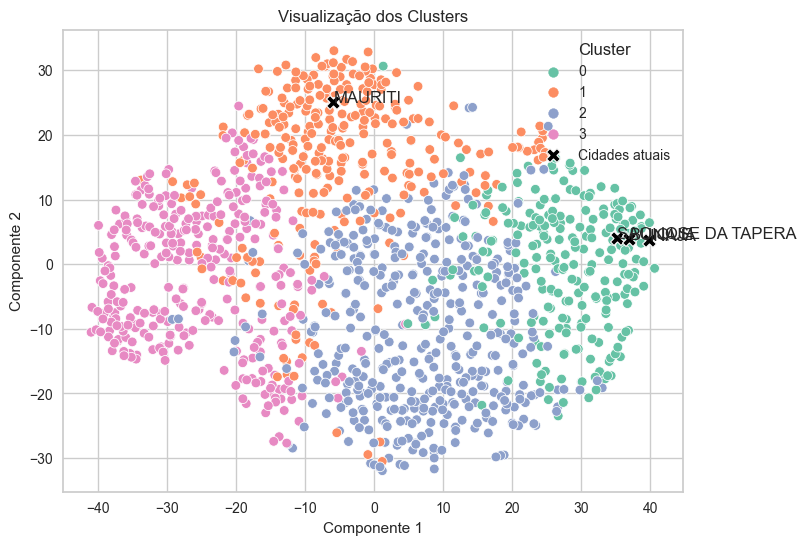

In [129]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_selected_pca)
print('Silhouette Score: ',round(silhouette_score(df_selected_pca, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_selected_pca, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_selected_pca, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

### 3.4.1) Interpretação dos clusters

In [130]:
df['CLUSTER'] = k_clusters
df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'REN_PIBPC_D', 
        'PANALF15', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'TRANSPORT_COST'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,REN_PIBPC_D,PANALF15,I_FREQ_PROP,T_DES18M,TRANSPORT_COST
CLUSTER,,,,,,,,
0,0.545130,13316.529004,127540.911688,5.185463,18.565494,0.540494,6.570346,25978.841504
1,0.596596,17687.243206,135256.212544,5.282520,15.892846,0.650443,6.921951,26536.187742
2,0.582252,16160.914352,113016.943519,5.846453,14.999670,0.587759,8.432523,25364.786698
3,0.634441,39984.744695,170898.257878,7.645158,12.744338,0.658318,7.900707,25235.270487


### 3.4.1) Interpretação dos municípios atuais

In [131]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'REN_PIBPC_D', 
        'PANALF15', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'TRANSPORT_COST',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,REN_PIBPC_D,PANALF15,I_FREQ_PROP,T_DES18M,TRANSPORT_COST,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,4.9628,24.0088,0.536,4.33,24412.742090,0
418,MAURITI,0.605,46103.4,207315.4,5.2568,16.7412,0.632,8.31,26126.391541,1
796,BUIQUE,0.527,56502.4,234399.4,4.4988,18.5988,0.524,7.25,24856.786124,0
827,INAJA,0.523,21917.0,89734.8,4.7116,27.3100,0.471,7.35,24941.784481,0


### 3.4.1) Seleção dos municipios de maior potencial

In [132]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'REN_PIBPC_D', 
        'PANALF15', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'TRANSPORT_COST'
    ]
].loc[
    (potential_muns['CLUSTER'] == actual_cities[actual_cities["NOME"] == "BUIQUE"]["CLUSTER"].values[0])&
    (potential_muns['TRANSPORT_COST'] <= 26126)&
    (potential_muns['POP_TOT'] >= 21917)&
    (potential_muns['POP_TOT_30KM'] >= 89734)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,POP_TOT,POP_TOT_30KM,REN_PIBPC_D,PANALF15,I_FREQ_PROP,T_DES18M,TRANSPORT_COST
0,2916500,ITAPICURU,BA,0.486,35881.0,197766.2,7.5388,19.4064,0.462,9.86,23766.055025
1,2705002,MATA GRANDE,AL,0.504,25555.2,129923.6,4.5684,19.8512,0.499,1.57,24784.146031
2,2921500,MONTE SANTO,BA,0.506,53678.4,107356.8,4.0948,15.4988,0.494,4.55,24661.745267
3,2607505,ITAIBA,PE,0.510,26440.2,129160.2,4.9780,19.6016,0.497,4.11,24766.124221
4,2615805,TUPANATINGA,PE,0.519,26445.0,135832.6,4.4652,20.8720,0.513,5.31,24850.504059
5,2603207,CAETES,PE,0.522,28139.2,275058.0,4.9432,17.3952,0.530,3.82,24577.226408
6,2702355,CRAIBAS,AL,0.525,24250.4,452771.8,4.5904,22.8964,0.554,2.73,24157.623963
7,2600500,AGUAS BELAS,PE,0.526,42556.6,120915.8,4.9760,21.9588,0.484,6.76,24567.583714
8,2805406,POCO REDONDO,SE,0.529,33748.0,160430.8,5.6608,17.0088,0.489,6.55,24384.862047
9,2709202,TRAIPU,AL,0.532,27788.4,125736.2,4.3304,24.6008,0.527,3.71,24050.952763


In [ ]:
final_df = df[df['IBGE7'].isin(potential_muns['IBGE7'])].sort_values(by='IDHM').reset_index().drop(columns='index')
final_df.to_csv('../Dados/Tabela_final/municipios_potenciais.csv')